First import required packages and functions.

In [1]:
import scipy.io as sio
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.distributions import Normal

from tqdm import tqdm_notebook

# Indiana Pines

Load the data.

In [2]:
def load_data(img_path, target_path, img_dict_el, target_dict_el):
    """Given imformation about the path and the location of the data, loads it and then transforms.
    
    Parameters
    ----------
    img_path: str
        Path to the images.
    target_path: str
        Path to the ground truth labels.
    img_dict_el: str
        Dictionary sell where the images are stored.
    target_dict_el: str
        Dictionary sell where the target labels are stored.
        
    Returns
    -------
    X: numpy.ndarray
        Loaded and transformed images.
    y: numpy.ndarray
        Loaded and transformed for the future convenience labels
    """
    X = sio.loadmat(img_path)[img_dict_el]
    y = sio.loadmat(target_path)[target_dict_el]
    
    for cl in np.unique(y): # See the class labels' distribution.
        print(cl, np.sum(y == cl))
    
    # Shift and scale it so that it will have zero mean and unit standard deviation.
    X = X.transpose((2, 0, 1))
    C, H, W = X.shape
    X = X.reshape(1, C, H, W)
    dataset_mean = X.mean()
    dataset_std = X.std()
    X = (X - dataset_mean) / dataset_std
    y = y.reshape(-1) # repeat y for convenient use of classificator
    return X, y

In [3]:
X, y = load_data('data/Indian_pines_corrected.mat', 'data/Indian_pines_gt.mat', 'indian_pines_corrected', 'indian_pines_gt')

0 10776
1 46
2 1428
3 830
4 237
5 483
6 730
7 28
8 478
9 20
10 972
11 2455
12 593
13 205
14 1265
15 386
16 93


Define encoder and decoder.

In [4]:
def init_autoencoder(X, in_channels=200, lr=0.001, reg=0):
    encoder = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=100, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=100),
                        nn.Conv2d(in_channels=100, out_channels=50, kernel_size=3, padding=1),
                        nn.ReLU(), 
                        nn.BatchNorm2d(num_features=50))
    decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=50, out_channels=100, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=100),
                            nn.ConvTranspose2d(in_channels=100, out_channels=in_channels, kernel_size=5, padding=2),
                            nn.ReLU())
    
    # define loss as MSE and optimization method as Adam. Also convert the dataset to the PyTorch format
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001, weight_decay=reg)
    img = Variable(torch.FloatTensor(X.copy()))
    return (encoder, decoder, optimizer, loss_function), img

In [5]:
def train_autoencoder(model, img, epochs=5):
    """Trains defined globally called encoder-decoder network.
    
    Parameters
    ----------
    img: torch.autograd.Variable.
        Dataset to train the net
    epochs: int, default: 5
        Number of passes through the full dataset.
        
    Returns
    -------
    loss: float
        Result loss value.
    """
    encoder, decoder, optimizer, loss_function = model
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad() # set gradient values to zero. Just PyTorch stuff
        encoder_out = encoder(img) # get encoded image
        decoder_out = decoder(encoder_out) # and then decode it
        loss = loss_function(decoder_out, img) # calculate the loss value
        losses.append(loss.data.numpy().copy()[0])
        loss.backward() # and compute gradients
        optimizer.step() # make optimization step
        print(loss.data.numpy().copy()[0])
        
    encoder_out = encoder(img)
    decoder_out = decoder(encoder_out)
    loss = loss_function(decoder_out, img)
    return loss

def plt_map(act_map):
    """Plots given activation map of the convolution layer.
    
    Parameters
    ----------
    act_map: torch.autograd.Variable
        Activation map which will be plotted
    """
    N = act_map.data.shape[0]
    
    plt.figure(figsize=(10, 10))
    _, axes = plt.subplots(N // 10 + int(N % 10), 10)
    for ax in axes.reshape(-1):
        ax.axis('off')
    for i, filter_ in enumerate(act_map.data.numpy()):
        axes[i // 10, i % 10].imshow(filter_);
    plt.show();
        
def get_and_plot_act_map(encoder, img):
    """Extracts layer and it's activation map passed one image.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
        
    Returns:
    activations: torch.autograd.Variable
        activation map on the first convolutional layer.
    """
    
    _, first_layer = list(encoder._modules.items())[0] # get networks' first layer 
    activations = first_layer(img) # and get activation values
    plt_map(activations.squeeze())
    return activations

Train the model.

1.047327
1.0096511
0.9116219
0.8252319
0.78764427
0.74213237
0.7152566
0.6834388
0.6546252
0.6398084
0.62052727
0.6039465
0.5900729
0.5752474
0.55940175
0.5454731


<Figure size 720x720 with 0 Axes>

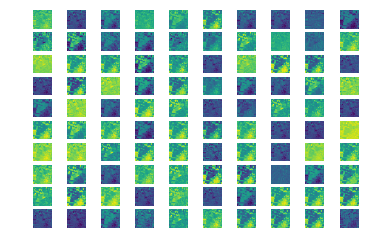

Variable containing:
 0.5307
[torch.FloatTensor of size 1]



In [6]:
model, img = init_autoencoder(X)
reconstruction_error = train_autoencoder(model, img, 16) # save reconstruction error
activations = get_and_plot_act_map(model[0], img) # save activations of the first convolutional layer
print(reconstruction_error)

In [7]:
def get_classification_error(encoder, img, y):
    """Gets dataset, splits it to the training and validation set, 
    fits LogisticRegression(ANN) and returns misclassified pixels percentage.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
    y: numpy.ndarray
        Ground truth labels of the given dataset.
        
    Returns
    -------
    error: float
        Misclassification of pixels percentage.
    """
    encoder.training = False
    features_raw = encoder(img) # get encoder output
    features_raw = features_raw.data.numpy() # and conert it to the numpy
    
    # flatten and split to the training and validation parts to fit LogisticRegression(ANN) on this data
    N, C, H, W = features_raw.shape
    features = features_raw.reshape(C, -1)
    features = features.T

    features_train, features_valid, y_train, y_valid = train_test_split(features, y, test_size=0.3)
    
    # fitting it
    logreg = LogisticRegression()
    logreg.fit(features_train, y_train) # train ANN, with cross entropy loss function
    
    # and predicting the values and getting misclassification percentage
    error = 1 - accuracy_score(y_valid, logreg.predict(features_valid))
    return error

In [8]:
error = get_classification_error(model[0], img, y)
print(error)

0.3462270133164236


# Salinas-A

Now let's fine-tune autoencoder and classifier to check their performance on the Salinas-A dataset.

In [9]:
X, y = load_data('data/SalinasA_corrected.mat', 'data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt')
img = Variable(torch.FloatTensor(X.copy()))

0 1790
1 391
10 1343
11 616
12 1525
13 674
14 799


1.0491147
0.98431313
0.84905934
0.744447
0.69394934
0.6580473
0.63315207
0.6149623
0.5909601
0.56161344
0.5376305


<Figure size 720x720 with 0 Axes>

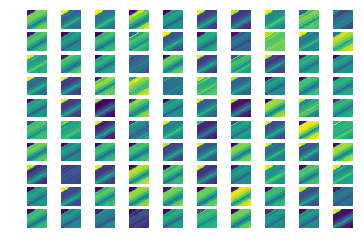

Variable containing:
 0.5195
[torch.FloatTensor of size 1]



In [10]:
model, img = init_autoencoder(X, in_channels=204)
reconstruction_error = train_autoencoder(model, img, epochs=11)
activations = get_and_plot_act_map(model[0], img)
print(reconstruction_error)

In [11]:
error = get_classification_error(model[0], img, y)
print(error)

0.1489262371615313


# Compare
It can be seen that first dataset requires much more training and even after that shows less performance. It should be caused by the dataset's properites.

In [18]:
!cd ..; git add test_proj/autoencoder_to_dim_reduce

fatal: pathspec 'test_proj/autoencoder_to_dim_reduce' did not match any files
